# 1. Introduction<a id="10"></a>

This competition requires us to predict future sales for Russian firm 1C Company. Our submission will contain next month sales predictions for 5100 items at each of 42 shops, with predictions being clipped into the range (0,20). The performance metric is RMSE. To inform these predictions we are given sales data covering the 33 months prior to the test period. For the (shop,item) pairs we are trying to predict, the following possibilities exist:
1. This pair exists in our training set
2. The item is in our training set, but not with the shop
3. The item is not in our training set at all

Our model needs to be capable of making predictions in all three cases.

**Attached datasets**

I initially used previously uploaded datasets containing english translations of item/category/shop names. I found that item names in those datasets had not been translated in their entirety, so I have attached an english translated dataset with complete translations. 

I have also attached a dataset which contains the dataframe our initial model is trained with and the initial model itself. These can be loaded to skip directly to modelling with the dataset or exploring the model's predictions.

**Contents**

Multiple other notebooks have already done an excellent job covering EDA, such as [this notebook](https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data/) by the holder of the current 4th place leaderboard submission.

[1. Introduction](#10)  
[2. Preparing Dataset](#20)  
&nbsp;&nbsp;[2.1 Preparing Item/Category Information](#21)  
&nbsp;&nbsp;[2.2 Preparing Sales Information](#22)  
&nbsp;&nbsp;[2.3 Constructing Training Dataframe](#23)  
&nbsp;&nbsp;[2.4 Adding Shop Information](#24)  
&nbsp;&nbsp;[2.5 Ages & Aggregating Sales/Price information](#25)  
&nbsp;&nbsp;[2.6 Lagging Values & Features that use Prior Information](#26)  
&nbsp;&nbsp;[2.7 Encoding Name Information](#27)  
[3. Modelling](#30)  
&nbsp;&nbsp;[3.1 Training Model](#31)  
&nbsp;&nbsp;[3.2 Submitting](#32)  
[4. Analysing Model Output](#40)  
&nbsp;&nbsp;[4.1 Plots](#41)  
&nbsp;&nbsp;[4.2 Table Views](#42) 

**Results**

This notebook has a submission attached which achieves a leaderboard score of 0.85389. Using this submission as a base to improve on by incorporating findings gleaned in [Section 4](#40) allowed me to achieve a leaderboard score of 0.82501.
![Leaderboard at time of posting](https://i.imgur.com/GiMxp8O.png)

Leave a comment if the code is insufficiently explained at any point or you find any errors, and good luck with your own attempts! 👍

In [1]:
import pandas as pd
import numpy as np
from itertools import product
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import category_encoders as ce
import warnings

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 160)
pd.set_option('display.max_colwidth', 40)
warnings.filterwarnings("ignore")

# 2. Preparing Training Dataset & Feature Engineering<a id="20"></a>

[1. Introduction](#10)  
[2. Preparing Dataset](#20)  
&nbsp;&nbsp;[2.1 Preparing Item/Category Information](#21)  
&nbsp;&nbsp;[2.2 Preparing Sales Information](#22)  
&nbsp;&nbsp;[2.3 Constructing Training Dataframe](#23)  
&nbsp;&nbsp;[2.4 Adding Shop Information](#24)  
&nbsp;&nbsp;[2.5 Ages & Aggregating Sales/Price information](#25)  
&nbsp;&nbsp;[2.6 Lagging Values & Features that use Prior Information](#26)  
&nbsp;&nbsp;[2.7 Encoding Name Information](#27)  
[3. Modelling](#30)  
&nbsp;&nbsp;[3.1 Training Model](#31)  
&nbsp;&nbsp;[3.2 Submitting](#32)  
[4. Analysing Model Output](#40)  
&nbsp;&nbsp;[4.1 Plots](#41)  
&nbsp;&nbsp;[4.2 Table Views](#42)  

We'll be using shortened column names in this notebook to save some keystrokes and display more compactly. The submission file must name the target value 'item_cnt_month', but all sales data we work with will be monthly unless otherwise specified, so we will use 'item_cnt' until submission. The translated files already use category_id in place of item_category_id etc. 

We load the test set now as we'll soon be making use of the shop_id and item_id values.

In [2]:
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


**2.1 Preparing Item/Category Information** <a id="21"></a>

We load categories.csv and display the category names

In [3]:
categories = pd.read_csv('../input/predict-future-sales-eng-translation/categories.csv')
pd.DataFrame(categories.category_name.values.reshape(-1, 4))

,0,1,2,3
0,PC - Headsets / Headphones,Accessories - PS2,Accessories - PS3,Accessories - PS4
1,Accessories - PSP,Accessories - PSVita,Accessories - XBOX 360,Accessories - XBOX ONE
2,Tickets (Digital),Delivery of goods,Game consoles - PS2,Game consoles - PS3
3,Game consoles - PS4,Game consoles - PSP,Game consoles - PSVita,Game consoles - XBOX 360
4,Game consoles - XBOX ONE,Game consoles - Others,Games - PS2,Games - PS3
5,Games - PS4,Games - PSP,Games - PSVita,Games - XBOX 360
6,Games - XBOX ONE,Games - Game accessories,Android games - Number,MAC Games - Number
7,PC Games - Additional Editions,PC Games - Collector's Editions,PC Games - Standard Editions,PC Games - Digital
8,"Payment Cards (Cinema, Music, Games)",Payment Cards - Live!,Payment Cards - Live! (Digital),Payment cards - PSN
9,Payment cards - Windows (Digital),Cinema - Blu-Ray,Cinema - Blu-Ray 3D,Cinema - Blu-Ray 4K


Not all category names have a '-' between the main category and the subcategory. We create groups by extracting the part of the name prior to a non-letter character. We then create a group_id column by label encoding the group names.

In [4]:
#create broader category groupings
categories['group_name'] = categories['category_name'].str.extract(r'(^[\w\s]*)')
categories['group_name'] = categories['group_name'].str.strip()
#label encode group names
categories['group_id']  = le.fit_transform(categories.group_name.values)
categories.sample(5)

,category_name,category_id,group_name,group_id
1,Accessories - PS2,1,Accessories,0
24,Games - XBOX ONE,24,Games,8
20,Games - PS4,20,Games,8
64,Gifts - Board games,64,Gifts,9
17,Game consoles - Others,17,Game consoles,7


We load items.csv, clean the name column, create multiple features based on the cleaned name, and use label encoding. The categories dataframe is then joined to the items dataframe.

In [5]:
#load items
items = pd.read_csv('../input/predict-future-sales-eng-translation/items.csv')

#clean item_name
items['item_name'] = items['item_name'].str.lower()
items['item_name'] = items['item_name'].str.replace('.', '')
for i in [r'[^\w\d\s\.]', r'\bthe\b', r'\bin\b', r'\bis\b',
          r'\bfor\b', r'\bof\b', r'\bon\b', r'\band\b',  
          r'\bto\b', r'\bwith\b' , r'\byo\b']:
    items['item_name'] = items['item_name'].str.replace(i, ' ')
items['item_name'] = items['item_name'].str.replace(r'\b.\b', ' ')

#extract first n characters of name
items['item_name_no_space'] = items['item_name'].str.replace(' ', '')
items['item_name_first4'] = [x[:4] for x in items['item_name_no_space']]
items['item_name_first6'] = [x[:6] for x in items['item_name_no_space']]
items['item_name_first11'] = [x[:11] for x in items['item_name_no_space']]
del items['item_name_no_space']
                              
#label encode these columns
items.item_name_first4 = le.fit_transform(items.item_name_first4.values)
items.item_name_first6 = le.fit_transform(items.item_name_first6.values)
items.item_name_first11 = le.fit_transform(items.item_name_first11.values)

#join category_name, group_name and group_id to items
items = items.join(categories.set_index('category_id'), on='category_id')
items.sample(10)

,item_id,category_id,item_name,item_name_first4,item_name_first6,item_name_first11,category_name,group_name,group_id
14435,14435,40,masha bear beauty terrible power,2028,3685,6553,Cinema - DVD,Cinema,5
12588,12588,40,club mikki maus mikki str region,755,1360,2414,Cinema - DVD,Cinema,5
7009,7009,2,thrustmaster f1 wireless gamepad fer...,3329,6131,10925,Accessories - PS3,Accessories,0
2972,2972,30,dmc devil may cry pc jewel russia...,964,1808,3262,PC Games - Standard Editions,PC Games,13
2857,2857,19,disney epic mickey two legends p...,951,1790,3216,Games - PS3,Games,8
5664,5664,3,ps4 4gamers gaming headset starter ...,2648,4754,8541,Accessories - PS4,Accessories,0
20417,20417,72,figure batman arkham city series b...,1203,2187,3981,Gifts - Figures,Gifts,9
17451,17451,40,about mammotenka sb region,135,173,262,Cinema - DVD,Cinema,5
2338,2338,31,call duty modern warfare conten...,642,1130,1966,PC Games - Digital,PC Games,13
18614,18614,40,sex by obmenu,2998,5418,9689,Cinema - DVD,Cinema,5


Duplicate rows exist in the item list. The following cell creates a dictionary that will allow us to reassign item id's where appropriate.

In [6]:
dupes = items[(items.duplicated(subset=['item_name','category_id'],keep=False))]
dupes['in_test'] = dupes.item_id.isin(test.item_id.unique())
dupes = dupes.groupby('item_name').agg({'item_id':['first','last'],'in_test':['first','last']})

#if both item id's are in the test set do nothing
dupes = dupes[(dupes[('in_test', 'first')]==False) | (dupes[('in_test', 'last')]==False)]
#if only the first id is in the test set assign this id to both
temp = dupes[dupes[('in_test', 'first')]==True]
keep_first = dict(zip(temp[('item_id', 'last')], temp[('item_id',  'first')]))
#if neither id or only the second id is in the test set, assign the second id to both
temp = dupes[dupes[('in_test', 'first')]==False]
keep_second = dict(zip(temp[('item_id', 'first')], temp[('item_id',  'last')]))
item_map = {**keep_first, **keep_second}

**2.2 Preparing Sales Information** <a id="22"></a>

We load sales.csv, remove the small proportion of rows without outlying values, use the dictionary we created above to reassign item id's where appropriate, then filter out sales for shops that don't exist in the test set and create features that need to be made before the data is grouped by month.

In [7]:
#loading sales data
sales = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
sales = (sales
    .query('0 < item_price < 50000 and 0 < item_cnt_day < 1001') #removing outliers
    .replace({
        'shop_id':{0:57, 1:58, 11:10}, #replacing obsolete shop id's
        'item_id':item_map #fixing duplicate item id's  
    })    
)

#removing shops which don't appear in the test set
sales = sales[sales['shop_id'].isin(test.shop_id.unique())]

sales['date'] = pd.to_datetime(sales.date,format='%d.%m.%Y')
sales['weekday'] = sales.date.dt.dayofweek

#first day the item was sold, day 0 is the first day of the training set period
sales['first_sale_day'] = sales.date.dt.dayofyear 
sales['first_sale_day'] += 365 * (sales.date.dt.year-2013)
sales['first_sale_day'] = sales.groupby('item_id')['first_sale_day'].transform('min').astype('int16')

#revenue is needed to accurately calculate prices after grouping
sales['revenue'] = sales['item_cnt_day']*sales['item_price']

We calculate the proportion of weekly sales that occurred on each weekday at each shop. Using this information we can assign a measure of weeks of sales power to each month. February always has 4 exactly weeks worth of days since there are no leap years in our time range and all other months have a value >4 since they have extra days of varying sales power. 

Month, year and first day of the month features are also created.

In [8]:
temp = sales.groupby(['shop_id','weekday']).agg({'item_cnt_day':'sum'}).reset_index()
temp = pd.merge(temp, sales.groupby(['shop_id']).agg({'item_cnt_day':'sum'}).reset_index(), on='shop_id', how='left')
temp.columns = ['shop_id','weekday', 'shop_day_sales', 'shop_total_sales']
temp['day_quality'] = temp['shop_day_sales']/temp['shop_total_sales']
temp = temp[['shop_id','weekday','day_quality']]

dates = pd.DataFrame(data={'date':pd.date_range(start='2013-01-01',end='2015-11-30')})
dates['weekday'] = dates.date.dt.dayofweek
dates['month'] = dates.date.dt.month
dates['year'] = dates.date.dt.year - 2013
dates['date_block_num'] = dates['year']*12 + dates['month'] - 1
dates['first_day_of_month'] = dates.date.dt.dayofyear
dates['first_day_of_month'] += 365 * dates['year']
dates = dates.join(temp.set_index('weekday'), on='weekday')
dates = dates.groupby(['date_block_num','shop_id','month','year']).agg({'day_quality':'sum','first_day_of_month':'min'}).reset_index()

dates.query('shop_id == 28').head(15)

,date_block_num,shop_id,month,year,day_quality,first_day_of_month
18,0,28,1,0,4.300037,1
60,1,28,2,0,4.000000,32
102,2,28,3,0,4.605952,60
144,3,28,4,0,4.193211,91
186,4,28,5,0,4.333970,121
228,5,28,6,0,4.472819,152
270,6,28,7,0,4.287644,182
312,7,28,8,0,4.492718,213
354,8,28,9,0,4.313648,244
396,9,28,10,0,4.300037,274


We now group the sales data by month, shop_id a

In [9]:
sales = (sales
     .groupby(['date_block_num', 'shop_id', 'item_id'])
     .agg({
         'item_cnt_day':'sum', 
         'revenue':'sum',
         'first_sale_day':'first'
     })
     .reset_index()
     .rename(columns={'item_cnt_day':'item_cnt'})
)
sales.sample(5)

,date_block_num,shop_id,item_id,item_cnt,revenue,first_sale_day
987284,23,42,17978,1.0,149.0,276
158861,3,25,8576,1.0,149.0,1
683594,15,31,15438,1.0,599.0,1
1229990,30,55,10586,4.0,1196.0,134
1102267,26,45,13961,1.0,148.0,288


**2.3 Constructing Training Dataframe** <a id="23"></a>

The test set consists of the cartesian product of 42 shops and 5100 items. To make a training set which approximates the test set we create a training dataframe consisting of the cartesian product (active items) x (active shops) for each month.

In [10]:
df = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]]))))

df = pd.DataFrame(np.vstack(df), columns=['shop_id', 'item_id', 'date_block_num'])
df.head()

,shop_id,item_id,date_block_num
0,2,27,0
1,2,33,0
2,2,317,0
3,2,438,0
4,2,471,0


In [11]:
#add the appropriate date_block_num value to the test set
test['date_block_num'] = 34
del test['ID']

In [12]:
#append test set to training dataframe
df = pd.concat([df,test]).fillna(0)
df = df.reset_index()
del df['index']

In [13]:
#join sales and item inforamtion to the training dataframe
df = pd.merge(df, sales, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)
df = pd.merge(df, dates, on=['date_block_num','shop_id'], how='left')
df = pd.merge(df, items.drop(columns=['item_name','group_name','category_name']), on='item_id', how='left')

**2.4 Adding Shop Information** <a id="24"></a>

We cluster the shops using K-means clustering, using the proportion of their sales they make in each category as features.

k=7 was selected because:
* k=7 resulted in the highest average silhouette score aside from a choice of k=2. 
* k=2 would not provide a useful clustering because it creates a feature with value (shop_id==55)\*1. 
* k=7 is also in an appropriate area when using the elbow method

In [14]:
#loading shops.csv
shops = pd.read_csv('../input/predict-future-sales-eng-translation/shops.csv')

#clustering shops
shops_cats = pd.DataFrame(
    np.array(list(product(*[df['shop_id'].unique(), df['category_id'].unique()]))),
    columns =['shop_id', 'category_id']
)
temp = df.groupby(['category_id', 'shop_id']).agg({'item_cnt':'sum'}).reset_index()
temp2 = temp.groupby('shop_id').agg({'item_cnt':'sum'}).rename(columns={'item_cnt':'shop_total'})
temp = temp.join(temp2, on='shop_id')
temp['category_proportion'] = temp['item_cnt']/temp['shop_total']
temp = temp[['shop_id', 'category_id', 'category_proportion']]
shops_cats = pd.merge(shops_cats, temp, on=['shop_id','category_id'], how='left')
shops_cats = shops_cats.fillna(0)

shops_cats = shops_cats.pivot(index='shop_id', columns=['category_id'])
kmeans = KMeans(n_clusters=7, random_state=0).fit(shops_cats)
shops_cats['shop_cluster'] = kmeans.labels_.astype('int8')

#adding these clusters to the shops dataframe
shops = shops.join(shops_cats['shop_cluster'], on='shop_id')

We clean the shop names column then use the opening word to create the shop_city feature. We then create the shop_type feature based on terms that occur in the name of the shop. Both these features are then label encoded.

In [15]:
#removing unused shop ids
shops.dropna(inplace=True)

#cleaning the name column
shops['shop_name'] = shops['shop_name'].str.lower()
shops['shop_name'] = shops['shop_name'].str.replace(r'[^\w\d\s]', ' ')

#creating a column for the type of shop
shops['shop_type'] = 'regular'

#there is some overlap in tc and mall, mall is given precedence
shops.loc[shops['shop_name'].str.contains(r'tc'), 'shop_type'] = 'tc'
shops.loc[shops['shop_name'].str.contains(r'mall|center|mega'), 'shop_type'] = 'mall'
shops.loc[shops['shop_id'].isin([9,20]), 'shop_type'] = 'special'
shops.loc[shops['shop_id'].isin([12,55]), 'shop_type'] = 'online'

#the first word of shop name is largely sufficient as a city feature
shops['shop_city'] = shops['shop_name'].str.split().str[0]
shops.loc[shops['shop_id'].isin([12,55]), 'shop_city'] = 'online'
shops.shop_city = le.fit_transform(shops.shop_city.values)
shops.shop_type = le.fit_transform(shops.shop_type.values)
shops.head()

,shop_name,shop_id,shop_cluster,shop_type,shop_city
2,adygea tc mega,2,4.0,0,0
3,balashikha tc oktyabr kinomir,3,0.0,3,1
4,volga tc volga mall,4,0.0,0,22
5,vologda sec marmelad,5,0.0,2,23
6,voronezh plekhanovskaya 13,6,0.0,2,24


In [16]:
#add shop information to the training dataframe
df = pd.merge(df, shops.drop(columns='shop_name'), on='shop_id', how='left')
df.head()

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,first_day_of_month,category_id,item_name_first4,item_name_first6,item_name_first11,group_id,shop_cluster,shop_type,shop_city
0,2,27,0,1.0,2499.0,2.0,1,0,4.381749,1,19,2,2,2,8,4.0,0,0
1,2,33,0,1.0,499.0,2.0,1,0,4.381749,1,37,415,720,1203,5,4.0,0,0
2,2,317,0,1.0,299.0,4.0,1,0,4.381749,1,45,31,38,52,4,4.0,0,0
3,2,438,0,1.0,299.0,19.0,1,0,4.381749,1,45,31,38,57,4,4.0,0,0
4,2,471,0,2.0,798.0,3.0,1,0,4.381749,1,49,30,37,51,4,4.0,0,0


**2.5 Ages & Aggregating Sales/Price information** <a id="25"></a>

We create a feature showing how many days have passed between the first time an item was sold and the beginning of the current month.

In [17]:
df['first_sale_day'] = df.groupby('item_id')['first_sale_day'].transform('max').astype('int16')
df.loc[df['first_sale_day']==0, 'first_sale_day'] = 1035
df['prev_days_on_sale'] = [max(idx) for idx in zip(df['first_day_of_month']-df['first_sale_day'],[0]*len(df))]
del df['first_day_of_month']

In [18]:
#freeing RAM, removing unneeded columns and encoding object columns
del sales, categories, shops, shops_cats, temp, temp2, test, dupes, item_map, 
df.head()

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,category_id,item_name_first4,item_name_first6,item_name_first11,group_id,shop_cluster,shop_type,shop_city,prev_days_on_sale
0,2,27,0,1.0,2499.0,2,1,0,4.381749,19,2,2,2,8,4.0,0,0,0
1,2,33,0,1.0,499.0,2,1,0,4.381749,37,415,720,1203,5,4.0,0,0,0
2,2,317,0,1.0,299.0,4,1,0,4.381749,45,31,38,52,4,4.0,0,0,0
3,2,438,0,1.0,299.0,19,1,0,4.381749,45,31,38,57,4,4.0,0,0,0
4,2,471,0,2.0,798.0,3,1,0,4.381749,49,30,37,51,4,4.0,0,0,0


We want to clip the target value before aggregating so that mean values are not distorted due to outliers. We retain the unclipped value for use in features that do not aggregate the sales data.

In [19]:
df['item_cnt_unclipped'] = df['item_cnt']
df['item_cnt'] = df['item_cnt'].clip(0, 20)

No columns with float dtype require more than float32 precision and no int dtype columns require values outside the int16 range. The following function will compress the data types of these columns.

In [20]:
def downcast(df):
    #reduce size of the dataframe
    float_cols = [c for c in df if df[c].dtype in ["float64"]]
    int_cols = [c for c in df if df[c].dtype in ['int64']]
    df[float_cols] = df[float_cols].astype('float32')
    df[int_cols] = df[int_cols].astype('int16')
    return df
df = downcast(df)

These features show how many months have passed since the first appearance of the item/name/category/group/shop

In [21]:
df['item_age'] = (df['date_block_num'] - df.groupby('item_id')['date_block_num'].transform('min')).astype('int8')
df['item_name_first4_age'] = (df['date_block_num'] - df.groupby('item_name_first4')['date_block_num'].transform('min')).astype('int8')
df['item_name_first6_age'] = (df['date_block_num'] - df.groupby('item_name_first6')['date_block_num'].transform('min')).astype('int8')
df['item_name_first11_age'] = (df['date_block_num'] - df.groupby('item_name_first11')['date_block_num'].transform('min')).astype('int8')
df['category_age'] = (df['date_block_num'] - df.groupby('category_id')['date_block_num'].transform('min')).astype('int8')
df['group_age'] = (df['date_block_num'] - df.groupby('group_id')['date_block_num'].transform('min')).astype('int8')
df['shop_age'] = (df['date_block_num'] - df.groupby('shop_id')['date_block_num'].transform('min')).astype('int8')

In [22]:
#indicates whether shops have previously sold the item
temp = df.query('item_cnt > 0').groupby(['item_id','shop_id']).agg({'date_block_num':'min'}).reset_index()
temp.columns = ['item_id', 'shop_id', 'item_shop_first_sale']
df = pd.merge(df, temp, on=['item_id','shop_id'], how='left')
df['item_shop_first_sale'] = df['item_shop_first_sale'].fillna(50)
#item age that stays at 0 if a shop hasn't sold the item
df['item_age_if_shop_sale'] = (df['date_block_num'] > df['item_shop_first_sale']) * df['item_age']
#the length of time an item has been for sale without being sold at individual shops
df['item_age_without_shop_sale'] = (df['date_block_num'] <= df['item_shop_first_sale']) * df['item_age']
del df['item_shop_first_sale']

The target variable, 'item_cnt', is the monthly sale count of individual items at individual shops. We now create features showing average monthly sales based on various groupings

In [23]:
def agg_cnt_col(df, merging_cols, new_col,aggregation):
    temp = df.groupby(merging_cols).agg(aggregation).reset_index()
    temp.columns = merging_cols + [new_col]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#individual items across all shops
df = agg_cnt_col(df, ['date_block_num','item_id'],'item_cnt_all_shops',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','category_id','shop_id'],'item_cnt_all_shops_median',{'item_cnt':'median'}) 
#all items in category at individual shops
df = agg_cnt_col(df, ['date_block_num','category_id','shop_id'],'category_cnt',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','category_id','shop_id'],'category_cnt_median',{'item_cnt':'median'}) 
#all items in category across all shops
df = agg_cnt_col(df, ['date_block_num','category_id'],'category_cnt_all_shops',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','category_id'],'category_cnt_all_shops_median',{'item_cnt':'median'})
#all items in group
df = agg_cnt_col(df, ['date_block_num','group_id','shop_id'],'group_cnt',{'item_cnt':'mean'})
#all items in group across all shops
df = agg_cnt_col(df, ['date_block_num','group_id'],'group_cnt_all_shops',{'item_cnt':'mean'})
#all items at individual shops
df = agg_cnt_col(df, ['date_block_num','shop_id'],'shop_cnt',{'item_cnt':'mean'})
#all items at all shops within the city
df = agg_cnt_col(df, ['date_block_num','shop_city'],'city_cnt',{'item_cnt':'mean'})

We now create features showing the mean first month sales for items in each category

In [24]:
def new_item_sales(df, merging_cols, new_col):
    temp = (
        df
        .query('item_age==0')
        .groupby(merging_cols)['item_cnt']
        .mean()
        .reset_index()
        .rename(columns={'item_cnt': new_col})
    )
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#mean units sold of new item in category at individual shop
df = new_item_sales(df, ['date_block_num','category_id','shop_id'], 'new_items_in_cat')
#mean units sold of new item in category across all shops
df = new_item_sales(df, ['date_block_num','category_id'], 'new_items_in_cat_all_shops')

In [25]:
def agg_price_col(df, merging_cols, new_col):
    temp = df.groupby(merging_cols).agg({'revenue':'sum','item_cnt_unclipped':'sum'}).reset_index()
    temp[new_col] = temp['revenue']/temp['item_cnt_unclipped']
    temp = temp[merging_cols + [new_col]]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#average item price
df = agg_price_col(df,['date_block_num','item_id'],'item_price')
#average price of items in category
df = agg_price_col(df,['date_block_num','category_id'],'category_price')
#average price of all items
df = agg_price_col(df,['date_block_num'],'block_price')

In [26]:
df = downcast(df)

**2.6 Lagging Values & Features that use Prior Information** <a id="26"></a>

The following function will be used to create lag features of varying lag periods.

In [27]:
def lag_feature(df, lag, col, merge_cols):        
    temp = df[merge_cols + [col]]
    temp = temp.groupby(merge_cols).agg({f'{col}':'first'}).reset_index()
    temp.columns = merge_cols + [f'{col}_lag{lag}']
    temp['date_block_num'] += lag
    df = pd.merge(df, temp, on=merge_cols, how='left')
    df[f'{col}_lag{lag}'] = df[f'{col}_lag{lag}'].fillna(0).astype('float32')
    return df

These features each have 3 lagged columns returned:
* lag1 shows the value of the prior month
* lag2 shows the value two months prior
* lag1to12 is the sum of values across the previous 12 months

Original columns will be deleted when they are no longer needed to avoid data leakage.

In [28]:
lag12_cols = {
    'item_cnt':['date_block_num', 'shop_id', 'item_id'],
    'item_cnt_all_shops':['date_block_num', 'item_id'],
    'category_cnt':['date_block_num', 'shop_id', 'category_id'],
    'category_cnt_all_shops':['date_block_num', 'category_id'],
    'group_cnt':['date_block_num', 'shop_id', 'group_id'],
    'group_cnt_all_shops':['date_block_num', 'group_id'],
    'shop_cnt':['date_block_num', 'shop_id'],
    'city_cnt':['date_block_num', 'shop_city'],
    'new_items_in_cat':['date_block_num', 'shop_id', 'category_id'],
    'new_items_in_cat_all_shops':['date_block_num', 'category_id']
}
for col,merge_cols in lag12_cols.items():
    df[f'{col}_lag1to12'] = 0
    for i in range(1,13):
        df = lag_feature(df, i, col, merge_cols)
        df[f'{col}_lag1to12'] += df[f'{col}_lag{i}']
        if i > 2:
            del df[f'{col}_lag{i}']
    if col == 'item_cnt':
        del df[f'{col}_lag1']
        del df[f'{col}_lag2']        
    else:
        del df[col]

We take lag1 and lag2 values for these columns

In [29]:
lag2_cols = {
    'item_cnt_unclipped':['date_block_num', 'shop_id', 'item_id'],
    'item_cnt_all_shops_median':['date_block_num', 'item_id'],
    'category_cnt_median':['date_block_num', 'shop_id', 'category_id'],
    'category_cnt_all_shops_median':['date_block_num', 'category_id']
}
for col in lag2_cols:
    df = lag_feature(df, 1, col, merge_cols)
    df = lag_feature(df, 2, col, merge_cols)
    if col!='item_cnt_unclipped':
        del df[col]

These features show the ratio between lag1 and lag1to12 values

In [30]:
df['item_cnt_diff'] = df['item_cnt_unclipped_lag1']/df['item_cnt_lag1to12']
df['item_cnt_all_shops_diff'] = df['item_cnt_all_shops_lag1']/df['item_cnt_all_shops_lag1to12']
df['category_cnt_diff'] = df['category_cnt_lag1']/df['category_cnt_lag1to12']
df['category_cnt_all_shops_diff'] = df['category_cnt_all_shops_lag1']/df['category_cnt_all_shops_lag1to12']

We create lag1 values for category and block prices.

In [31]:
df = lag_feature(df, 1, 'category_price',['date_block_num', 'category_id'])
df = lag_feature(df, 1, 'block_price',['date_block_num'])
del df['category_price'], df['block_price']

We fill the missing values in the below columns with 0 because we know this is the correct value.

In [32]:
df.loc[(df['item_age']>0) & (df['item_cnt_lag1to12'].isna()), 'item_cnt_lag1to12'] = 0
df.loc[(df['category_age']>0) & (df['category_cnt_lag1to12'].isna()), 'category_cnt_lag1to12'] = 0
df.loc[(df['group_age']>0) & (df['group_cnt_lag1to12'].isna()), 'group_cnt_lag1to12'] = 0

Currently, lag1to12 values are the sum of values over the previous 12 months. Differing ages in the dataset mean that some lag1to12 values are calculated over the previous 12 months, but others have had less time to accrue. 

We divide lag1to12 values by the minimum between 12 and previous periods in the dataset. This turns lag1to12 into a monthly average that can be more accurately compared between datapoints.

In [33]:
df['item_cnt_lag1to12'] /= [min(idx) for idx in zip(df['item_age'],df['shop_age'],[12]*len(df))]
df['item_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['item_age'],[12]*len(df))]
df['category_cnt_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],df['shop_age'],[12]*len(df))]
df['category_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],[12]*len(df))]
df['group_cnt_lag1to12'] /= [min(idx) for idx in zip(df['group_age'],df['shop_age'],[12]*len(df))]
df['group_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['group_age'],[12]*len(df))]
df['city_cnt_lag1to12'] /= [min(idx) for idx in zip(df['date_block_num'],[12]*len(df))]
df['shop_cnt_lag1to12'] /= [min(idx) for idx in zip(df['shop_age'],[12]*len(df))]
df['new_items_in_cat_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],df['shop_age'],[12]*len(df))]
df['new_items_in_cat_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],[12]*len(df))]

In [34]:
df = downcast(df)

These features use past information across more than one period of the dataset. They are not suitable to be lagged in the normal manner.

In [35]:
def past_information(df, merging_cols, new_col, aggregation):
    temp = []
    for i in range(1,35):
        block = df.query(f'date_block_num < {i}').groupby(merging_cols).agg(aggregation).reset_index()
        block.columns = merging_cols + [new_col]
        block['date_block_num'] = i
        block = block[block[new_col]>0]
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on=['date_block_num']+merging_cols, how='left')
    return df

#average item price in latest block item was sold
df = past_information(df, ['item_id'],'last_item_price',{'item_price':'last'})
#total units of item sold at individual shop
df = past_information(df, ['shop_id','item_id'],'item_cnt_sum_alltime',{'item_cnt':'sum'})
#total units of item sold at all shops
df = past_information(df, ['item_id'],'item_cnt_sum_alltime_allshops',{'item_cnt':'sum'})

#these columns are no longer needed, and would cause data leakage if retained
del df['revenue'], df['item_cnt_unclipped'], df['item_price']

Feature showing item prices relative to the block price.

In [36]:
df['relative_price_item_block_lag1'] = df['last_item_price']/df['block_price_lag1']

These features show per day sales values since an item was first sold.

In [37]:
df['item_cnt_per_day_alltime'] = (df['item_cnt_sum_alltime']/df['prev_days_on_sale']).fillna(0)
df['item_cnt_per_day_alltime_allshops'] = (df['item_cnt_sum_alltime_allshops']/df['prev_days_on_sale']).fillna(0)

In [38]:
import gc
gc.collect()
df = downcast(df)

These features show the mean sales of items with names that have the same first n characters, in the same category and at the same item age. The hope is that this feature can catch past performance of similar items such as earlier titles in a series, particularly in their debut month.

In [39]:
def matching_name_cat_age(df,n,all_shops):
    temp_cols = [f'same_name{n}catage_cnt','date_block_num', f'item_name_first{n}','item_age','category_id']
    if all_shops:
        temp_cols[0] += '_all_shops'
    else:
        temp_cols += ['shop_id']
    temp = []
    for i in range(1,35):
        block = (
            df
            .query(f'date_block_num < {i}')
            .groupby(temp_cols[2:])
            .agg({'item_cnt':'mean'})
            .reset_index()
            .rename(columns={'item_cnt':temp_cols[0]})
        )
        block = block[block[temp_cols[0]]>0]
        block['date_block_num'] = i
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on=temp_cols[1:], how='left')
    return df

for n in [4,6,11]:
    for all_shops in [True,False]:
        df = matching_name_cat_age(df,n,all_shops)

In [40]:
#assign appropriate datatypes
df = downcast(df)
int8_cols = [
    'item_cnt','month','group_id','shop_type',
    'shop_city','shop_id','date_block_num','category_id',
    'item_age',
]
int16_cols = [
    'item_id','item_name_first4',
    'item_name_first6','item_name_first11'
]
for col in int8_cols:
    df[col] = df[col].astype('int8')
for col in int16_cols:
    df[col] = df[col].astype('int16')

These features show sales data for items with item_id 1 above and 1 below the item in question.

In [41]:
def nearby_item_data(df,col):
    if col in ['item_cnt_unclipped_lag1','item_cnt_lag1to12']:
        cols = ['date_block_num', 'shop_id', 'item_id']
        temp = df[cols + [col]] 
    else:
        cols = ['date_block_num', 'item_id']
        temp = df.groupby(cols).agg({col:'first'}).reset_index()[cols + [col]]   
    
    temp.columns = cols + [f'below_{col}']
    temp['item_id'] += 1
    df = pd.merge(df, temp, on=cols, how='left')
    
    temp.columns = cols + [f'above_{col}']
    temp['item_id'] -= 2
    df = pd.merge(df, temp, on=cols, how='left')
    
    return df

item_cols = ['item_cnt_unclipped_lag1','item_cnt_lag1to12',
             'item_cnt_all_shops_lag1','item_cnt_all_shops_lag1to12']
for col in item_cols:
    df = nearby_item_data(df,col)
    
del temp

**2.7 Encoding Name Information** <a id="27"></a>

We add boolean features indicating whether an item's name contains any words which frequently appear in the item set.

In [42]:
results = Counter()
items['item_name'].str.split().apply(results.update)

words = []
cnts = []
for key, value in results.items():
    words.append(key)
    cnts.append(value)
    
counts = pd.DataFrame({'word':words,'count':cnts})
common_words = counts.query('count>200').word.to_list()
for word in common_words:
    items[f'{word}_in_name'] = items['item_name'].str.contains(word).astype('int8')
drop_cols = [
    'item_id','category_id','item_name','item_name_first4',
    'item_name_first6','item_name_first11',
    'category_name','group_name','group_id'
]
items = items.drop(columns=drop_cols)

In [43]:
#join these word vectors to the training dataframe
df = df.join(items, on='item_id')

Given it's high cardinality, we use binary encoding to create a better representation of item_name_first11. The other name features are now deleted.

In [44]:
def binary_encode(df, letters, cols):
    encoder = ce.BinaryEncoder(cols=[f'item_name_first{letters}'], return_df=True)
    temp = encoder.fit_transform(df[f'item_name_first{letters}'])
    df = pd.concat([df,temp], axis=1)
    del df[f'item_name_first{letters}_0']
    name_cols = [f'item_name_first{letters}_{x}' for x in range(1,cols)]
    df[name_cols] = df[name_cols].astype('int8')
    return df

df = binary_encode(df, 11, 15)
    
del df['item_name_first4'], df['item_name_first6']

In [45]:
#save dataframe for later use
df.to_pickle('df_complete.pkl')

In [46]:
#Reset the kernel to clear memory.
%reset -f

# 3. Modelling<a id="30"></a>
[1. Introduction](#10)  
[2. Preparing Dataset](#20)  
&nbsp;&nbsp;[2.1 Preparing Item/Category Information](#21)  
&nbsp;&nbsp;[2.2 Preparing Sales Information](#22)  
&nbsp;&nbsp;[2.3 Constructing Training Dataframe](#23)  
&nbsp;&nbsp;[2.4 Adding Shop Information](#24)  
&nbsp;&nbsp;[2.5 Ages & Aggregating Sales/Price information](#25)  
&nbsp;&nbsp;[2.6 Lagging Values & Features that use Prior Information](#26)  
&nbsp;&nbsp;[2.7 Encoding Name Information](#27)  
[3. Modelling](#30)  
&nbsp;&nbsp;[3.1 Training Model](#31)  
&nbsp;&nbsp;[3.2 Submitting](#32)  
[4. Analysing Model Output](#40)  
&nbsp;&nbsp;[4.1 Plots](#41)  
&nbsp;&nbsp;[4.2 Table Views](#42) 

In [47]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from plotly.subplots import make_subplots
import plotly.graph_objects as go

pd.set_option('display.max_rows', 160)
pd.set_option('display.max_columns', 160)
pd.set_option('display.max_colwidth', 30)

import warnings
warnings.filterwarnings("ignore")

We create the training, validation, and test sets. The first 2 months are not used for training as many feature values are likely to be misrepresentative in this period. 

The month of data directly before the test period is used as our validation set. 

In [48]:
#load the saved training dataframe
df = pd.read_pickle('../input/files-top-scoring-notebook-output-exploration/df_complete.pkl')

X_train = df[~df.date_block_num.isin([0,1,33,34])]
y_train = X_train['item_cnt']
del X_train['item_cnt']

X_val = df[df['date_block_num']==33]
y_val = X_val['item_cnt']
del X_val['item_cnt']

X_test = df[df['date_block_num']==34].drop(columns='item_cnt')
X_test = X_test.reset_index()
del X_test['index']

#free memory
del df

**3.1 Training Model** <a id="31"></a>

Hyperparameter values were selected using a gridsearch with ranges of values for num_leaves, feature_fraction, bagging_fraction and min_data_in_leaf. 

The combination of values which resulted in the lowest validation set RMSE was selected. 

Learning rate is set to 0.01 as this value results in a well-behaved learning curve. Default values for other hyperparameters were deemed appropriate.

The moderately sized gap between training set RMSE and validation set RMSE implies some overfitting may be occurring, however, no tweaking of hyperparameters to constrict model flexibility resulted in a lower validation RMSE.


In [49]:
def build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    model = lgb.train(params=params, train_set=lgb_train, valid_sets=(lgb_train, lgb_val), verbose_eval=50,
                     categorical_feature=cat_features)
    return model

In [50]:
#skip this cell if directly loading saved model 
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'min_data_in_leaf':10,
    'feature_fraction':0.7,
    'learning_rate': 0.01,
    'num_rounds': 1000,
    'early_stopping_rounds': 30,
    'seed': 1
}
#designating the categorical features which should be focused on
cat_features = ['category_id','month','shop_id','shop_city']

lgb_model = build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features)

#save model for later use
lgb_model.save_model('initial_lgb_model.txt')

Training until validation scores don't improve for 30 rounds
[50]	training's rmse: 0.97911	valid_1's rmse: 0.893649
[100]	training's rmse: 0.838612	valid_1's rmse: 0.807924
[150]	training's rmse: 0.763794	valid_1's rmse: 0.772154
[200]	training's rmse: 0.721081	valid_1's rmse: 0.755533
[250]	training's rmse: 0.693845	valid_1's rmse: 0.748022
[300]	training's rmse: 0.674154	valid_1's rmse: 0.7446
[350]	training's rmse: 0.659098	valid_1's rmse: 0.742785
[400]	training's rmse: 0.646513	valid_1's rmse: 0.741649
[450]	training's rmse: 0.635653	valid_1's rmse: 0.741166
[500]	training's rmse: 0.626085	valid_1's rmse: 0.740366
Early stopping, best iteration is:
[519]	training's rmse: 0.622781	valid_1's rmse: 0.740195


**If you wish to explore the model without retraining, it can be directly loaded by uncommenting and running the cell below**

In [51]:
#lgb_model = lgb.Booster(model_file='../input/files-top-scoring-notebook-output-exploration/initial_lgb_model.txt')#
#lgb_model.params['objective'] = 'rmse'

**3.2 Submitting** <a id="32"></a>

We use this model to predict on the test set, and clip the predictions into the range (0,20) before submitting. 

This achieves a score of 0.85389 on the public leaderboard.

In [52]:
submission = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')
submission['item_cnt_month'] = lgb_model.predict(X_test).clip(0,20)
submission[['ID', 'item_cnt_month']].to_csv('initial_lgb_submission.csv', index=False)

# 4. Analysing Model Output<a id="40"></a>
[1. Introduction](#10)  
[2. Preparing Dataset](#20)  
&nbsp;&nbsp;[2.1 Preparing Item/Category Information](#21)  
&nbsp;&nbsp;[2.2 Preparing Sales Information](#22)  
&nbsp;&nbsp;[2.3 Constructing Training Dataframe](#23)  
&nbsp;&nbsp;[2.4 Adding Shop Information](#24)  
&nbsp;&nbsp;[2.5 Ages & Aggregating Sales/Price information](#25)  
&nbsp;&nbsp;[2.6 Lagging Values & Features that use Prior Information](#26)  
&nbsp;&nbsp;[2.7 Encoding Name Information](#27)  
[3. Modelling](#30)  
&nbsp;&nbsp;[3.1 Training Model](#31)  
&nbsp;&nbsp;[3.2 Submitting](#32)  
[4. Analysing Model Output](#40)  
&nbsp;&nbsp;[4.1 Plots](#41)  
&nbsp;&nbsp;[4.2 Table Views](#42)  

By looking more closely at the test set and our model output, we can make adjustments to improve on our initial model. The exploration shown below can provide insights that will allow us to make beneficial changes to the model.

In [53]:
#load item/category/shop information to make analysing the results easier
categories = pd.read_csv('../input/predict-future-sales-eng-translation/categories.csv')
categories['group_name'] = categories['category_name'].str.extract(r'(^[\w\s]*)')
categories['group_name'] = categories['group_name'].str.strip()

items = pd.read_csv('../input/predict-future-sales-eng-translation/items.csv')
items['item_name'] = items['item_name'].str.lower()
for i in [r'[^\w\d\s]', r'\bthe\b', r'\bin\b', r'\bfor\b', r'\bof\b', r'\bd\b', r'\bis\b', r'\bon\b']:
    items['item_name'] = items['item_name'].str.replace(i, ' ')
items['item_name'] = items['item_name'].str.replace(' ', '')
items = items.join(categories.set_index('category_id'), on='category_id')

shops = pd.read_csv('../input/predict-future-sales-eng-translation/shops.csv')
shops['shop_name'] = shops['shop_name'].str.lower()
shops['shop_name'] = shops['shop_name'].str.replace(r'[^\w\d\s]', ' ')
shops['shop_city'] = shops['shop_name'].str.split().str[0]
shops.loc[shops['shop_id'].isin([12,55]), 'shop_city'] = 'online'

We add columns showing predicted values, along with target values and sq_error for our training and validation sets

In [54]:
X_train['lgb_pred'] = lgb_model.predict(X_train).clip(0,20)
X_train['target'] = y_train
X_train['sq_err'] = (X_train['lgb_pred']-X_train['target'])**2

X_val['lgb_pred'] = lgb_model.predict(X_val).clip(0,20)
X_val['target'] = y_val
X_val['sq_err'] = (X_val['lgb_pred']-X_val['target'])**2

X_test['lgb_pred'] = lgb_model.predict(X_test).clip(0,20)

We create a dataframe that will allow us to easily graph some aspects of model's performance.

In [55]:
data = X_train.groupby('date_block_num').agg({'lgb_pred':'mean','target':'mean','sq_err':'mean'}).reset_index()
data['new_item_rmse'] = np.sqrt(X_train.query('item_age<=1').groupby('date_block_num').agg({'sq_err':'mean'}).sq_err)
data['old_item_rmse'] = np.sqrt(X_train.query('item_age>1').groupby('date_block_num').agg({'sq_err':'mean'}).sq_err)
data = data.append([
    {'date_block_num':33,
     'target':X_val.target.mean(),
     'lgb_pred':X_val.lgb_pred.mean(),
     'sq_err':np.sqrt(X_val.sq_err.mean()),
     'old_item_rmse':np.sqrt(X_val.query('item_age>1').sq_err.mean()),
     'new_item_rmse':np.sqrt(X_val.query('item_age<=1').sq_err.mean())},
    {'date_block_num':34,
     'target':0,
     'lgb_pred':X_test.lgb_pred.mean(),
     'sq_err':0,
     'old_item_rmse':0,
     'new_item_rmse':0}
    ],
    ignore_index=True
)
data['date'] = [x[:7] for x in pd.date_range(start='2013-03',end='2015-09',freq='MS').astype('str')]+['Validation','Test']

**4.1 Plots** <a id="41"></a>

A summary plot of feature importance. We can use this along with other [shap](https://shap.readthedocs.io/en/latest/) plots to get an idea of what drives the models predictions, and help us find spurious features which can be filtered out.

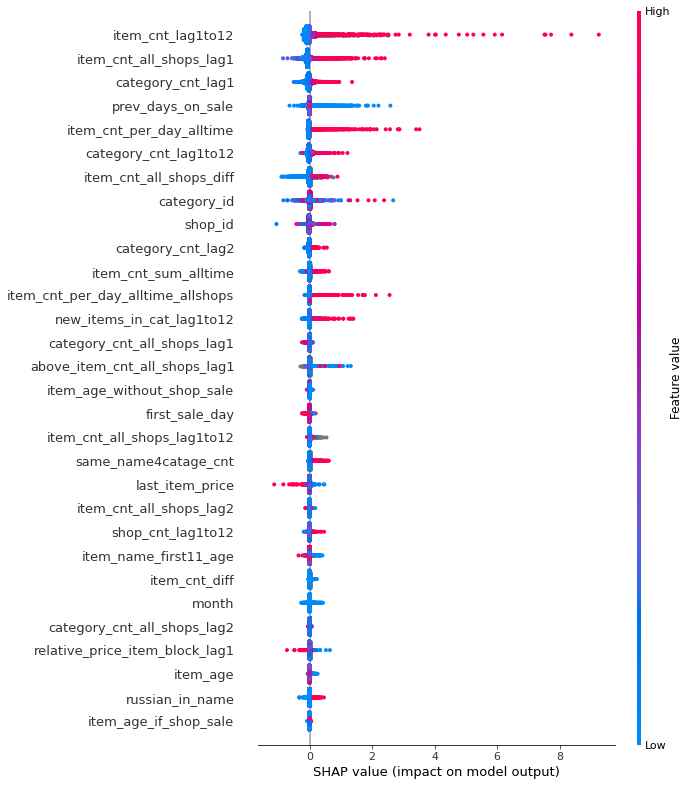

In [56]:
temp = X_test.drop(columns='lgb_pred').sample(10000)
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(temp)
shap.summary_plot(shap_values, temp, max_display=30)

In [57]:
fig = go.Figure(data=[
    go.Bar(name='Prediction',x=data.date,y=data.lgb_pred),
    go.Bar(name='Target',x=data.date,y=data.target)
])
fig.update_layout(
    title='Mean Prediction and Target Values by Month',
    xaxis={'title':'Month','type':'category'},
    yaxis={'title':'Mean Value'},
    legend={'yanchor':'top','y':1.05,'xanchor':'left','x':0.01},
    template='plotly_dark'
)

text = '''
    The model may not be adequately accounting for<br>
    the December sales spike. There is no systemic under or<br>
    over-prediction visible for the test month, November.
'''
fig.add_annotation(
    yref='paper', y=1.1,
    xref='paper', x=0.7,
    text=text,
    font={'size':11},
    showarrow=False)

text = '''
    Prediction mean is very close to the  <br> 
    target mean in our validation set.
'''
fig.add_annotation(
    xref='paper', x=0.95,
    yref='paper', y=0.58,
    text=text,
    font={'size':11},
    showarrow=True, arrowhead=1)
fig.show()

In [58]:
fig = go.Figure(data=[go.Bar(
    x=data.date[:-1],
    y=data.sq_err[:-1],
    marker_color=[x%12 for x in range(2,34)]
)])
fig.update_layout(
    title='RMSE by Month',
    xaxis={'title':'Month','type':'category'},
    yaxis={'title':'RMSE'},
    template='plotly_dark'
)
text = '''
    In the training set, RMSE is highest in December. <br>
    
'''
fig.add_annotation(
    yref='paper', y=0.9,
    xref='paper', x=0.1,
    text=text,
    font={'size':11},
    showarrow=False)
text = '''
    Validation RMSE is higher than in any month of <br>
    the training set. This is expected given the <br>
    gap in training set and validation set RMSE we <br>
    saw when training the model.
'''
fig.add_annotation(
    yref='paper', y=1.1,
    xref='paper', x=1,
    text=text,
    font={'size':11},
    showarrow=False)
fig.show()

In [59]:
temp = X_val.groupby('item_age').agg({'sq_err':'mean','target':'mean'}).reset_index()
temp['sq_err'] = np.sqrt(temp['sq_err'])
fig = go.Figure(data=[
    go.Bar(name='RMSE',x=temp.item_age,y=temp.sq_err)
])
fig.update_layout(
    title='Validation set RMSE by Item Age',
    xaxis={'title':'Item Age','type':'category'},
    yaxis={'title':'RMSE'},
    template='plotly_dark'
)
text = '''
    RMSE is much higher for items with age 0 or 1. There is a <br>
    sharp decrease in RMSE between ages 0 and 2, then a much <br>
    flatter downwards trend as age increases beyond 2.
'''
fig.add_annotation(
    yref='paper', y=0.8,
    xref='paper', x=0.04,
    text=text,
    font={'size':11},
    showarrow=False)
fig.show()

In [60]:
fig = go.Figure(data=[
    go.Bar(name='Item Age <=1 RMSE',x=data.date[:-1],y=data.new_item_rmse[:-1]),
    go.Bar(name='Item Age > 1 RMSE',x=data.date[:-1],y=data.old_item_rmse[:-1])
])
fig.update_layout(
    title='RMSE by Month for New and Old Items',
    xaxis={'title':'Month','type':'category'},
    yaxis={'title':'Mean Value'},
    legend={'yanchor':'top','y':1.05,'xanchor':'left','x':0.01},
    template='plotly_dark'
)
text = '''
    For older items, performance on the validation set is no worse than <br>
    performance on the training set. The higher overall validation set <br>
    RMSE is caused by a significantly higher RMSE for new items.
'''
fig.add_annotation(yref='paper', y=1.1,
                   xref='paper', x=0.93,
                   text=text,
                   font={'size':11},
                   showarrow=False)
fig.show()

**4.2 Table Views** <a id="42"></a>

There are 42 shops in our dataset. The following view shows us which shops have previously sold any items from each category. 

In [61]:
df = pd.read_pickle('../input/files-top-scoring-notebook-output-exploration/df_complete.pkl')
(
df
[df['category_id'].isin(X_test.category_id.unique())]
.query('item_cnt>0')
.groupby('category_id')
.agg({
    'category_age':'max',
    'shop_id':['nunique','unique'],
    'item_cnt':'sum'
    })
.join(categories['category_name'])
.join(
    X_test       
    .groupby('category_id')
    .agg({'item_id':'nunique'})
    .rename(columns={'item_id':'test_set_items'})
)
.sort_values(('shop_id', 'nunique'))
.head(20)
)

,"(category_age, max)","(shop_id, nunique)","(shop_id, unique)","(item_cnt, sum)",category_name,test_set_items
category_id,,,,,,
27,10,1,[55],8.0,MAC Games - Number,1
44,29,1,[55],252.0,Books - Audiobooks (Digit),7
36,2,1,[55],22.0,Payment cards - Windows (...,2
34,15,1,[55],1554.0,Payment Cards - Live! (Di...,5
31,29,1,[55],24249.0,PC Games - Digital,277
26,10,1,[55],107.0,Android games - Number,2
74,13,1,[55],59.0,Programs - MAC (Digit),1
76,29,1,[55],3906.0,Programs - For home and o...,61
54,29,1,[55],6063.0,Books - Digital,38


The following view shows which shops are causing the most loss in our validation set. Shops 25, 31, 42, and 28 have the highest MSEs but also the highest target means (we would expect to see MSE scale with target mean). Shops 12 and 55 have the next highest MSEs, and do not have relatively high target means. These are the only two shops which have a category only they sell. Could they benefit from being segregated in the training stage?

In [62]:
(
X_val
[X_val['category_id'].isin(X_test.category_id.unique())]
.groupby('shop_id')
.agg({
    'sq_err':'mean',
    'target':'mean',
    'lgb_pred':'mean'
})
.join(
    X_test
    .rename(columns={'lgb_pred':'test_pred'})
    .groupby('shop_id')
    .agg({'test_pred':'mean'})
)
.join(shops['shop_name'])
.sort_values('sq_err', ascending=False)
.head(20)
)

,sq_err,target,lgb_pred,test_pred,shop_name
shop_id,,,,,
25,2.376279,1.003423,0.881963,1.030379,moscow tec atrium
31,2.065357,1.017497,1.025834,1.134855,moscow tc semenovsky
42,1.924455,0.678014,0.626568,0.723926,st petersburg nevsky cen...
28,1.097571,0.523393,0.592135,0.649106,moscow tc mega teply sta...
55,0.870118,0.308102,0.272851,0.304235,digital warehouse 1c online
12,0.690278,0.241537,0.282187,0.307139,internet shop of emergenc...
21,0.674974,0.332065,0.307924,0.363238,moscow mtrc afi mall
39,0.653594,0.158996,0.137601,0.167353,rostovnadonu sec megacen...
47,0.631731,0.307531,0.322340,0.360220,surgut sec city mall


The following view shows which categories are causing the most loss in our validation set, and how prominent these categories are within the test set. Looking at their MSE and presence in the test set shows us that the video game categories are the causing the most loss and might warrant especially close examination.

In [63]:
(
X_val
[X_val['category_id'].isin(X_test.category_id.unique())]
.groupby('category_id')
.agg({
    'sq_err':['sum','mean'],
    'target':'mean',
    'lgb_pred':['sum','mean'],
    'item_id':'nunique'
})
.join(
    X_test
    .rename(columns={'lgb_pred':'test_pred','item_id':'test_items'})
    .groupby('category_id')        
    .agg({
        'test_pred':['sum','mean'],
        'test_items':'nunique'
    }),
    on='category_id'
)
.join(categories)
.sort_values(('sq_err', 'mean'), ascending=False)
.head(20)
)

,"(sq_err, sum)","(sq_err, mean)","(target, mean)","(lgb_pred, sum)","(lgb_pred, mean)","(item_id, nunique)","(test_pred, sum)","(test_pred, mean)","(test_items, nunique)",category_name,category_id,group_name
category_id,,,,,,,,,,,,
71,916.011122,21.809789,18.285714,712.066623,16.953967,1,713.625670,16.991087,1,"Gifts - Bags, Albums, Mou...",71,Gifts
79,441.960684,10.522873,11.047619,480.717438,11.445653,1,497.787252,11.852077,1,Service,79,Service
20,25683.666387,5.411645,1.186262,5832.263401,1.228880,113,7005.914097,1.217573,137,Games - PS4,20,Games
35,898.581561,5.348700,3.946429,639.695598,3.807712,4,723.276070,4.305215,4,Payment cards - PSN,35,Payment cards
83,757.015060,4.506042,2.053571,272.636247,1.622835,4,344.602865,2.051208,4,Batteries,83,Batteries
42,1483.959131,3.925818,1.690476,809.121146,2.140532,9,1124.089973,2.230337,12,"Books - Artbooks, encyclo...",42,Books
28,7215.550009,3.014014,0.882206,2017.547349,0.842752,57,3006.588121,1.213312,59,PC Games - Additional Edi...,28,PC Games
33,303.895222,2.411867,1.365079,133.890552,1.062623,3,140.886197,1.677217,2,Payment Cards - Live!,33,Payment Cards
29,844.606958,2.234410,0.370370,233.464015,0.617630,9,742.944579,1.474096,12,PC Games - Collector's Ed...,29,PC Games


The following view shows which items have the least accurate predictions across all shops in the validation set. Changing the value of the CATEGORY variable will allow you to look through different categories of interest.

In [64]:
#edit this value to look through the biggest problem items in each category
CATEGORY = 20
(
items[
    items['item_id'].isin(X_val.item_id.unique()) & 
    items['item_id'].isin(X_test.item_id.unique())
]
[['category_id','category_name','item_id','item_name']]
.join(
    X_test
    .rename(columns={'lgb_pred':'test_pred'})
    .groupby('item_id')        
    .agg({'test_pred':'mean'}),
    on='item_id'
)
.join(
    X_val
    .groupby('item_id')
    .agg({
        'lgb_pred':'mean',
        'target':'mean',
        'sq_err':'mean',
        'same_name4catage_cnt_all_shops':'first',
        'new_items_in_cat_all_shops_lag1to12':'first',
        'item_cnt_all_shops_lag1':'first',
        'category_cnt_all_shops_lag1':'first',
        'item_cnt_sum_alltime_allshops':'first',
        'prev_days_on_sale':'first'
    })
    .rename(columns={
        'lgb_pred':'val_pred',
        'target':'val_target',  
    }),
    on='item_id'
)
.query(f'category_id=={CATEGORY}')
.sort_values('sq_err',ascending=False)
.rename(columns={
    'same_name4catage_cnt_all_shops':'name4mean',
    'new_items_in_cat_all_shops_lag1to12':'new_in_cat_mean',
    'item_cnt_all_shops_lag1':'item_cnt_lag1',
    'category_cnt_all_shops_lag1':'cat_cnt_lag1',
    'category_id':'cat',
    'item_cnt_sum_alltime_allshops':'item_cnt_alltime'
})
.head(20)
)

,cat,category_name,item_id,item_name,test_pred,val_pred,val_target,sq_err,name4mean,new_in_cat_mean,item_cnt_lag1,cat_cnt_lag1,item_cnt_alltime,prev_days_on_sale
10202,20,Games - PS4,10202,witcher3wildhuntsupplement...,6.913019,3.611978,14.785714,149.574758,13.243902,4.697596,0.000000,1.248911,NaN,0
1583,20,Games - PS4,1583,assassinscreedsyndicatespe...,4.989529,3.856921,12.380952,101.062253,5.559375,4.697596,0.000000,1.248911,NaN,0
7223,20,Games - PS4,7223,unchartednathandrakecollec...,4.601981,5.918095,14.142857,81.125217,NaN,4.697596,0.000000,1.248911,NaN,0
7224,20,Games - PS4,7224,unchartednathandrakecollec...,3.204636,4.930881,8.666667,35.825284,NaN,4.697596,0.000000,1.248911,NaN,0
2423,20,Games - PS4,2423,crewps4russianversion,3.167499,1.604381,5.690476,31.115242,1.926829,4.697596,2.585366,1.248911,312.0,131
17755,20,Games - PS4,17755,journeycollectorseditionps...,0.655242,4.778742,0.880952,17.575158,NaN,4.697596,0.000000,1.248911,NaN,0
1578,20,Games - PS4,1578,assassinscreedsyndicatebig...,3.271763,3.564460,4.714286,15.792767,5.559375,4.697596,0.000000,1.248911,NaN,0
3351,20,Games - PS4,3351,fifa16ps4russianversion,4.479815,10.200958,8.261905,15.727511,8.316667,4.697596,17.878048,1.248911,733.0,9
4055,20,Games - PS4,4055,justdance2016unlimitedps4r...,1.176575,4.198221,0.809524,12.974552,0.691667,4.697596,0.000000,1.248911,NaN,0
3445,20,Games - PS4,3445,farcry4ps4russianversion,1.185810,3.324481,1.357143,8.316655,0.317073,4.697596,6.170732,1.248911,765.0,232


The following view shows which items in each category have the highest prediction value across all shops in the test set. Again the CATEGORY variable can be changed to look through different categories of interest.

In [65]:
CATEGORY = 20  
(
items[items['item_id'].isin(X_test.item_id.unique())]
[['category_id','category_name','item_id','item_name']]
.join(
    X_test
    .groupby('item_id')
    .agg({
        'lgb_pred':'mean',
        'same_name4catage_cnt_all_shops':'first',
        'new_items_in_cat_all_shops_lag1to12':'first',
        'item_cnt_all_shops_lag1':'first',
        'category_cnt_all_shops_lag1':'first',
        'item_cnt_sum_alltime_allshops':'first',
        'prev_days_on_sale':'first'
    })
    .rename(columns={'lgb_pred':'test_pred'}),
    on='item_id'
)
.query(f'category_id=={CATEGORY}')
.sort_values('test_pred',ascending=False)
.rename(columns={
     'same_name4catage_cnt_all_shops':'name4mean',
     'new_items_in_cat_all_shops_lag1to12':'new_in_cat_mean',
     'item_cnt_all_shops_lag1':'item_cnt_lag1',
     'category_cnt_all_shops_lag1':'cat_cnt_lag1',
     'item_category_id':'cat',
     'item_cnt_sum_alltime_allshops':'item_cnt_alltime'
})
.head(20)
)

,category_id,category_name,item_id,item_name,test_pred,name4mean,new_in_cat_mean,item_cnt_lag1,cat_cnt_lag1,item_cnt_alltime,prev_days_on_sale
2427,20,Games - PS4,2427,crewwildruneditionps4russi...,7.349899,5.597561,4.668349,0.000000,1.186262,NaN,0
10202,20,Games - PS4,10202,witcher3wildhuntsupplement...,6.913019,7.231707,4.668349,14.785714,1.186262,621.0,19
5268,20,Games - PS4,5268,needspeedps4russianversion,5.957877,3.914530,4.668349,0.000000,1.186262,NaN,0
6732,20,Games - PS4,6732,starwarsbattlefrontps4russ...,5.948874,NaN,4.668349,0.000000,1.186262,NaN,0
2323,20,Games - PS4,2323,calldutyblackopsiiips4russ...,5.857031,2.757143,4.668349,0.000000,1.186262,NaN,0
2327,20,Games - PS4,2327,calldutyblackopsiiinuketow...,5.848434,2.757143,4.668349,0.000000,1.186262,NaN,0
3408,20,Games - PS4,3408,fallout4ps4russiansubtitles,5.393323,NaN,4.668349,0.000000,1.186262,NaN,0
6729,20,Games - PS4,6729,starwarsbattlefrontbattleg...,5.126898,NaN,4.668349,0.000000,1.186262,NaN,0
1583,20,Games - PS4,1583,assassinscreedsyndicatespe...,4.989529,4.364486,4.668349,12.380953,1.186262,520.0,9
10203,20,Games - PS4,10203,witcher3wildhuntsupplement...,4.947974,13.766129,4.668349,0.000000,1.186262,NaN,0


Using these final two views in tandem can help identify specific problematic items in the test set. It is easier to keep track of the information when all the columns can be seen at once in the wider view available when running the notebook.